In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

In [2]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
# %%capture
# import sys

# if 'google.colab' in sys.modules:
#     # Install packages in Colab
#     !pip install category_encoders==2.*
#     !pip install eli5
#     !pip install pandas-profiling==2.*
#     !pip install pdpbox
#     !pip install shap
#     !pip install geopandas

In [3]:
!pip install category_encoders==2.*
!pip install eli5
!pip install pandas-profiling==2.*
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 37.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.6.3 which is incompatible.
Looking in indexes: https

In [4]:
import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import warnings
import xgboost

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from eli5.sklearn import PermutationImportance
from ipywidgets import interact, fixed
from lightgbm import LGBMClassifier
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_interact_plot, pdp_plot
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


warnings.filterwarnings(action='ignore')

In [5]:
plt.rc('font', family='NanumBarunGothic') 

In [6]:
sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='whitegrid')

In [7]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

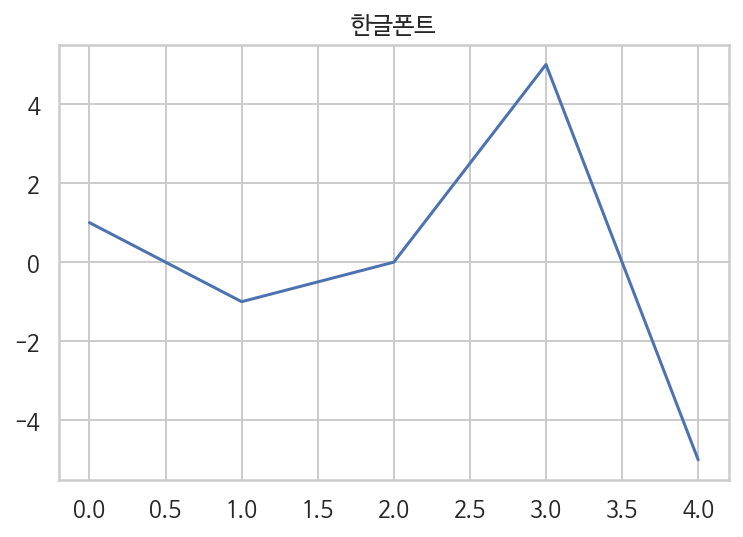

In [8]:
# 한글폰트 설정 확인을 합니다.

pd.Series([1, -1, 0, 5, -5]).plot(title="한글폰트")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
path = '/content/drive/MyDrive/Colab Notebooks/data/weatherAUS.csv'
df = pd.read_csv(path)

In [11]:
df.head(1)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No


# 프로젝트 목표
수집한 데이터를 통해 강우 여부를 예측하는 머신러닝 모델을 완성하고
해당 모델을 해석하여 정의한 문제를 해결할 수 있는 가설을 증명한다 

# 데이터셋 컬럼 정보
출처 :캐글(https://www.kaggle.com/) 데이터셋 검색 \
  -> [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) \
원본 출처 : 호주기상청 http://www.bom.gov.au/climate/data/

- 'Date' : 날짜
- 'Location' : 장소
- 'MinTemp' : 최저 온도 (섭씨)
- 'MaxTemp' : 최고 온도 (섭씨)
- 'Rainfall': 강수량 (mm)
- 'Evaporation' : 증발량 (mm)
- 'Sunshine' : 일조 시간 (hour)
- 'WindGustDir' : 가장 강한 바람 방향
- 'WindGustSpeed' : 가장 강한 바람 속도 (km/h)
- 'WindDir9am' : 오전 9시 바람 방향
- 'WindDir3pm' : 오후 3시 바람 방향
- 'WindSpeed9am': 오전 9시 바람 속도 (km/h)
- 'WindSpeed3pm': 오후 3시 바람 속도 (km/h)
- 'Humidity9am' : 오전 9시 습도 (%)
- 'Humidity3pm' : 오후 3시 습도 (%)
- 'Pressure9am' : 오전 9시에 평균 해수면으로 감소된 대기압(hpa)
- 'Pressure3pm' : 오후 3시에 평균 해수면으로 감소된 대기압(hpa)
- 'Cloud9am' : 오전 9시 구름량 (Many)
- 'Cloud3pm' : 오후 3시 구름량 (Many)
- 'Temp9am' : 오전 9시 온도 (섭씨)
- 'Temp3pm' : 오후 3시 온도 (섭씨)
- 'RainToday' : 오늘 강우 여부 (Boolean)
- 'RainTomorrow' : 내일 강우 여부 (Boolean)

# 데이터셋 선정한 근거
전세계적으로 코로나19에 대한 불안감이 줄고
여행에 대한 수요가 급증할 것.
여행사 기획팀은 겨울에도 따뜻한 나라에서 액티비티 여행을 원하는 고객들을 위해 계절이 반대인 호주에 새로운 여행 상품을 기획하려 한다.
액티비티 활동이 중요한 상품이라서 강우 여부에 따라 부분 환불 또는 전체 환불이 발생하여 사측에 수익이 줄어들고 고객과의 신뢰성이 하락할 수 있다.
상품을 기획할 호주의 강우 여부를 예측하는 모델을 통해 상품 스케줄을 기획한다면
액티비티상품의 취소,환불이 줄어들 것으로 예상된다.
---
# EDA



In [12]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [13]:
# 결측치 확인
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [14]:
# 중복값 확인
df.duplicated().sum()

0

In [15]:
# 결측치 비율 확인 후 비율이 30%가 넘는 컬럼 확인
missing_ratio = df.isnull().sum().sort_values(ascending=False) / df.shape[0]
missing_cols = missing_ratio[missing_ratio>0.3].index.tolist()
missing_cols

['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']

In [16]:
missing_ratio

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

In [17]:
# 타겟 설정
target = 'RainTomorrow'

In [18]:
# feature engineering

def engineer(df):
    df_copy = df.copy()

    # 결측치 비율이 30% 이상인 컬럼 drop
    df_copy.drop(['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'], axis=1, inplace=True)

    # datetime 타입 으로. 
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])

    # datetime 중 연도/월은 따로 컬럼 만들기
    # 계절 구분을 위해 분리 필요함
    df_copy['Year'] = df_copy['Date'].dt.year
    df_copy['Month'] = df_copy['Date'].dt.month

    # 'Summer' 컬럼 생성, 여름 시즌 (1), 비시즌(0) 으로 구분하여 저장
    # 호주의 여름은 12~2월
    summer_condition = (df_copy['Date'].dt.month == 12) | (df_copy['Date'].dt.month <= 2)
    df_copy['Summer'] = np.where(summer_condition, 1, 0)
    
    # target의 결측치 비율은 0.022460 -> 결측치 drop.
    df_copy.dropna(axis=0, how="any", subset=[target], inplace=True)

    # float64 타입의 결측치를 mean으로 대체. object 타입의 결측치는 최빈값으로 대체.
    columns = df_copy.columns
    for i in columns:
      if df_copy[i].dtype == 'float64':
        df_copy[i].fillna(df_copy[i].mean(), inplace=True)
      elif df_copy[i].dtype == 'object':
        df_copy[i].fillna(df_copy[i].mode().values[0], inplace=True)

    # 분류 문제로 해결하기 위해 Boolean 값을 int타입의 0과 1로 변경
    df_copy['RainToday'].replace('No', int(0), inplace=True)
    df_copy['RainToday'].replace('Yes', int(1), inplace=True)
    df_copy['RainToday'] = df_copy['RainToday'].astype(int)

    df_copy['RainTomorrow'].replace('No', int(0), inplace=True)
    df_copy['RainTomorrow'].replace('Yes', int(1), inplace=True)
    df_copy['RainTomorrow'] = df_copy['RainTomorrow'].astype(int)

    # 평균 기온 및 평균 습도
    # 최저값과 최고값을 더해 평균을 구하고
    # 최초 기록 시간대와 마지막 기록 시간대의 값의 평균으로 구함
    df_copy['AveTemp'] = (df_copy['MinTemp'] + df_copy['MaxTemp']) / 2 # 평균온도
    df_copy['AveHumidity'] = ((df_copy['Humidity3pm']) + (df_copy['Humidity9am'])) / 2 # 평균 습도
    df_copy['AveWindSpeed'] = (df_copy['WindSpeed9am'] + df_copy['WindSpeed3pm']) / 2 # 평균 바람 속도
    df_copy['AvePressure'] = (df_copy['Pressure9am'] + df_copy['Pressure3pm']) / 2 # 평균 해수면 감소 대기압



    # Date 컬럼은 drop
    df_copy.drop(['Date'], axis=1, inplace=True)
    
    # 필요하지 않은 컬럼들 drop (평균값 컬럼에 사용한 컬럼들 포함함)
    df_copy.drop(['MinTemp', 'MaxTemp', 'Humidity3pm', 'Humidity9am', 'Temp9am', 'Temp3pm', 
                  'WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm'], axis=1, inplace=True)

    return df_copy

df_preprocessed = engineer(df)
     

In [19]:
df_preprocessed

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,RainToday,RainTomorrow,Year,Month,Summer,AveTemp,AveHumidity,AveWindSpeed,AvePressure
0,Albury,0.6,W,44.0,W,WNW,0,0,2008,12,1,18.15,46.5,22.0,1007.40
1,Albury,0.0,WNW,44.0,NNW,WSW,0,0,2008,12,1,16.25,34.5,13.0,1009.20
2,Albury,0.0,WSW,46.0,W,WSW,0,0,2008,12,1,19.30,34.0,22.5,1008.15
3,Albury,0.0,NE,24.0,SE,E,0,0,2008,12,1,18.60,30.5,10.0,1015.20
4,Albury,1.0,W,41.0,ENE,NW,0,0,2008,12,1,24.90,57.5,13.5,1008.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,0.0,E,31.0,ESE,E,0,0,2017,6,0,12.65,43.0,14.0,1022.95
145455,Uluru,0.0,E,31.0,SE,ENE,0,0,2017,6,0,13.10,37.5,12.0,1022.45
145456,Uluru,0.0,NNW,22.0,SE,N,0,0,2017,6,0,14.45,38.5,11.0,1021.30
145457,Uluru,0.0,N,37.0,SE,WNW,0,0,2017,6,0,16.15,38.5,9.0,1018.90


In [20]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   Rainfall       142193 non-null  float64
 2   WindGustDir    142193 non-null  object 
 3   WindGustSpeed  142193 non-null  float64
 4   WindDir9am     142193 non-null  object 
 5   WindDir3pm     142193 non-null  object 
 6   RainToday      142193 non-null  int64  
 7   RainTomorrow   142193 non-null  int64  
 8   Year           142193 non-null  int64  
 9   Month          142193 non-null  int64  
 10  Summer         142193 non-null  int64  
 11  AveTemp        142193 non-null  float64
 12  AveHumidity    142193 non-null  float64
 13  AveWindSpeed   142193 non-null  float64
 14  AvePressure    142193 non-null  float64
dtypes: float64(6), int64(5), object(4)
memory usage: 17.4+ MB


In [21]:
df_preprocessed['WindGustDir'].value_counts()

W      19110
SE      9309
E       9071
N       9033
SSE     8993
S       8949
WSW     8901
SW      8797
SSW     8610
WNW     8066
NW      8003
ENE     7992
ESE     7305
NE      7060
NNW     6561
NNE     6433
Name: WindGustDir, dtype: int64

Baseline Accuracy: 0.7758187815152645


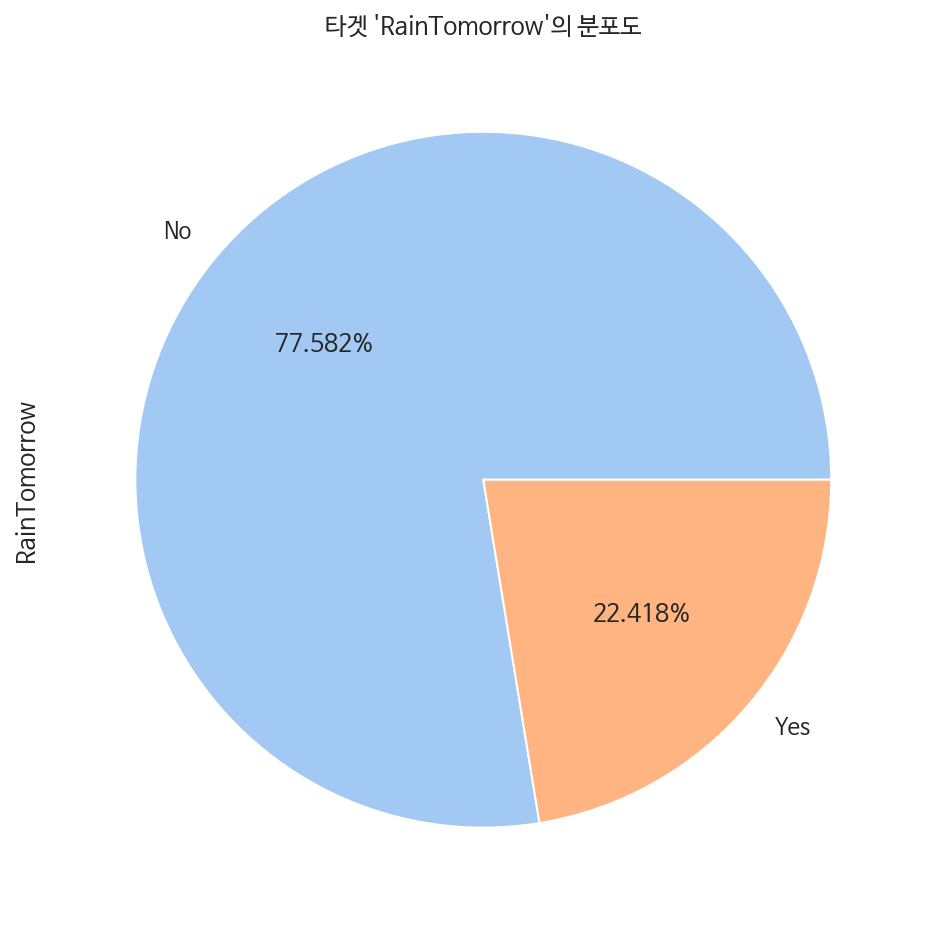

In [46]:
# 타겟의 분포도 확인
df[target].value_counts(normalize=True).plot.pie(autopct="%.3f%%")
plt.title("타겟 'RainTomorrow'의 분포도")
print("Baseline Accuracy:", df_preprocessed[target].value_counts(normalize=True).max())

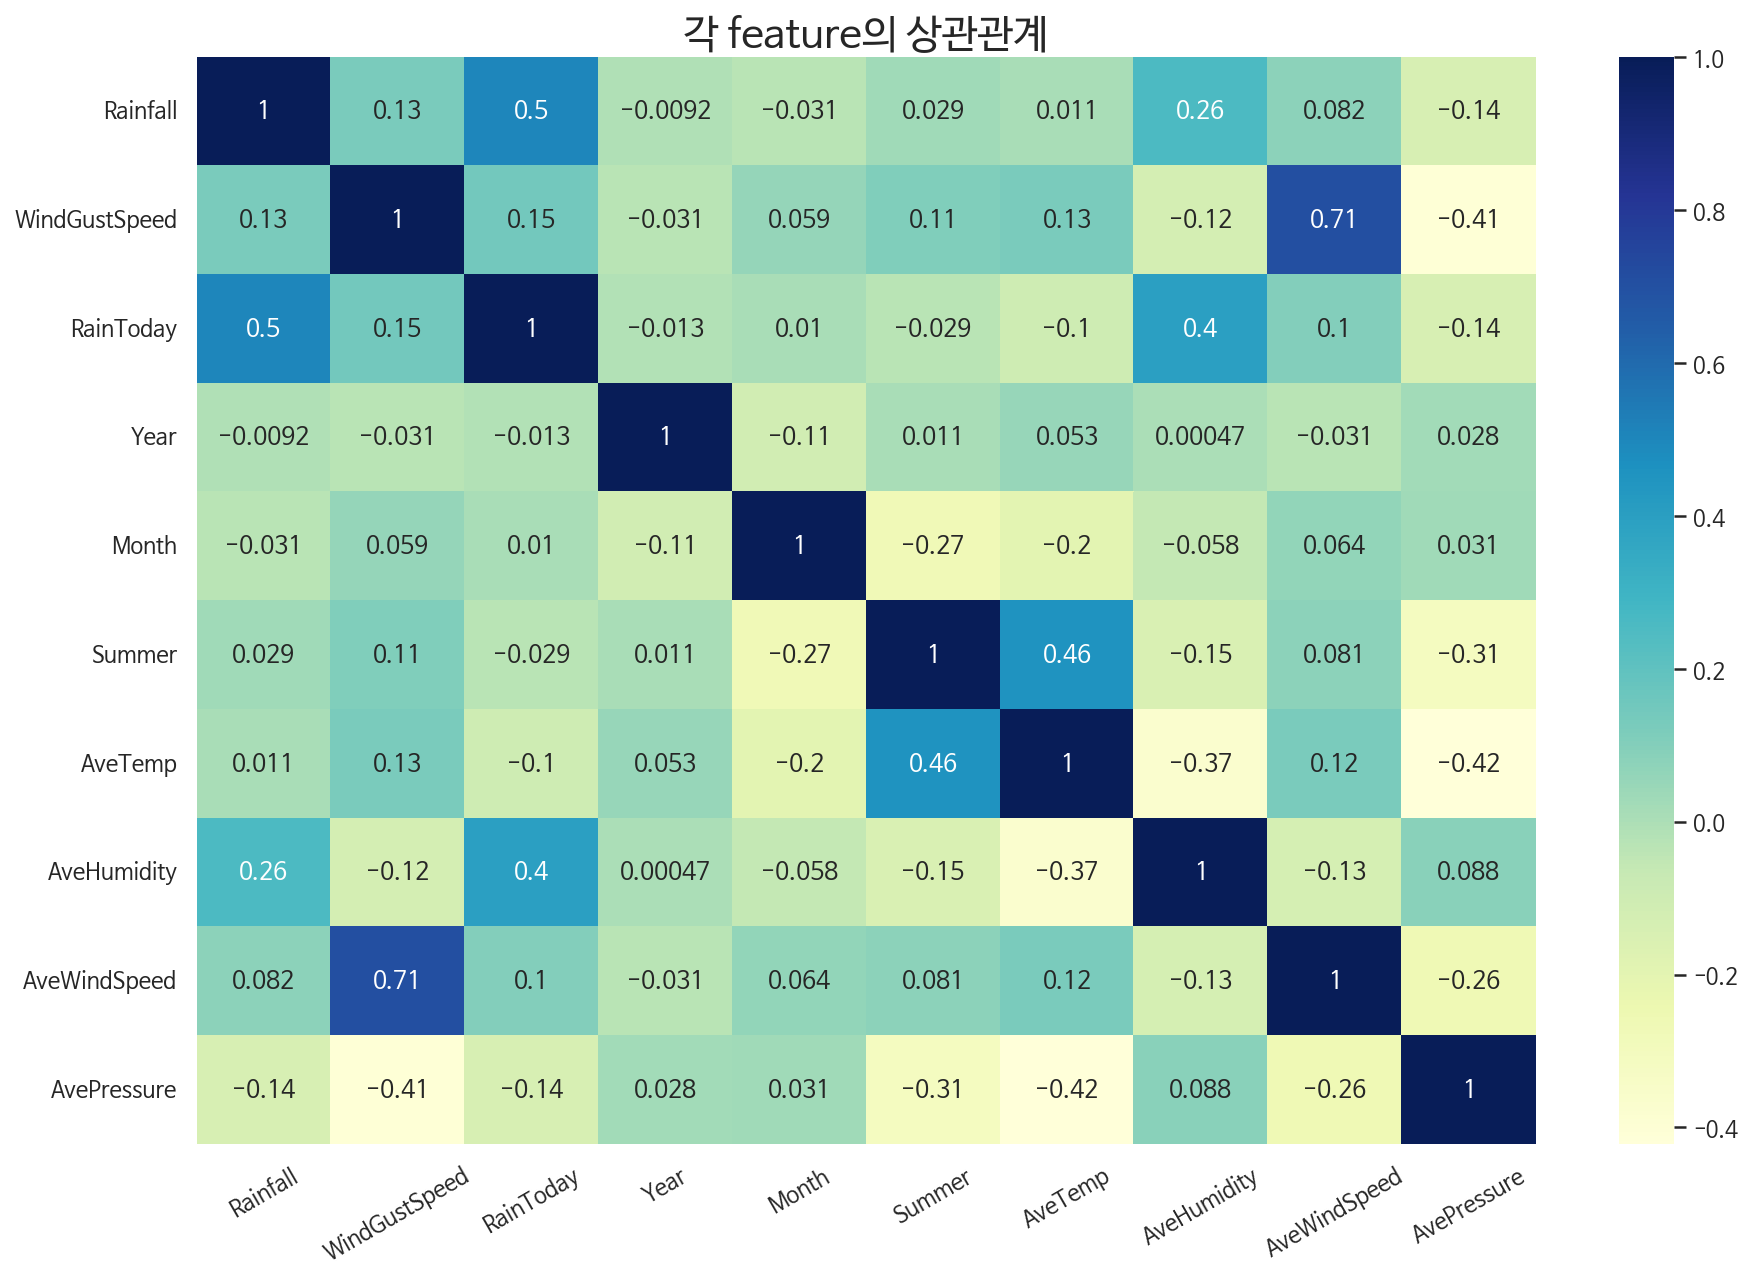

In [23]:
# feature 간 상관관계
df_corr = df_preprocessed.drop(target, axis=1)
plt.figure(figsize=(15, 10))
corr_heatmap = sns.heatmap(df_corr.corr(), annot=True, cmap='YlGnBu')
corr_heatmap.set_title('각 feature의 상관관계', fontsize=20)
corr_heatmap.set_ylim(10,0) # y축 짤림현상 조정
plt.xticks(rotation=30)
plt.show()

In [24]:
df_ave = df_preprocessed.groupby('Location')['AveTemp', 'Rainfall', 'AveHumidity'].mean().reset_index()
df_ave.head()

,Location,AveTemp,Rainfall,AveHumidity
0,Adelaide,17.786833,1.589805,52.232141
1,Albany,16.519803,2.255703,69.214463
2,Albury,16.078686,1.928529,60.995401
3,AliceSprings,21.183539,0.872286,31.888806
4,BadgerysCreek,17.581748,2.210399,64.120292


In [25]:
df_month_rainfall = df_preprocessed[['Month', 'Rainfall', 'AveTemp']]
df_month_rainfall = df_month_rainfall.groupby('Month')['Rainfall', 'AveTemp'].mean().reset_index()
df_month_rainfall

,Month,Rainfall,AveTemp
0,1,2.715494,23.512864
1,2,3.165149,23.170964
2,3,2.796076,21.382352
3,4,2.315063,18.219660
4,5,1.982420,14.841659
5,6,2.776556,12.589673
6,7,2.181038,11.873966
7,8,2.032715,12.875356
8,9,1.880991,15.123908
9,10,1.616621,17.537013


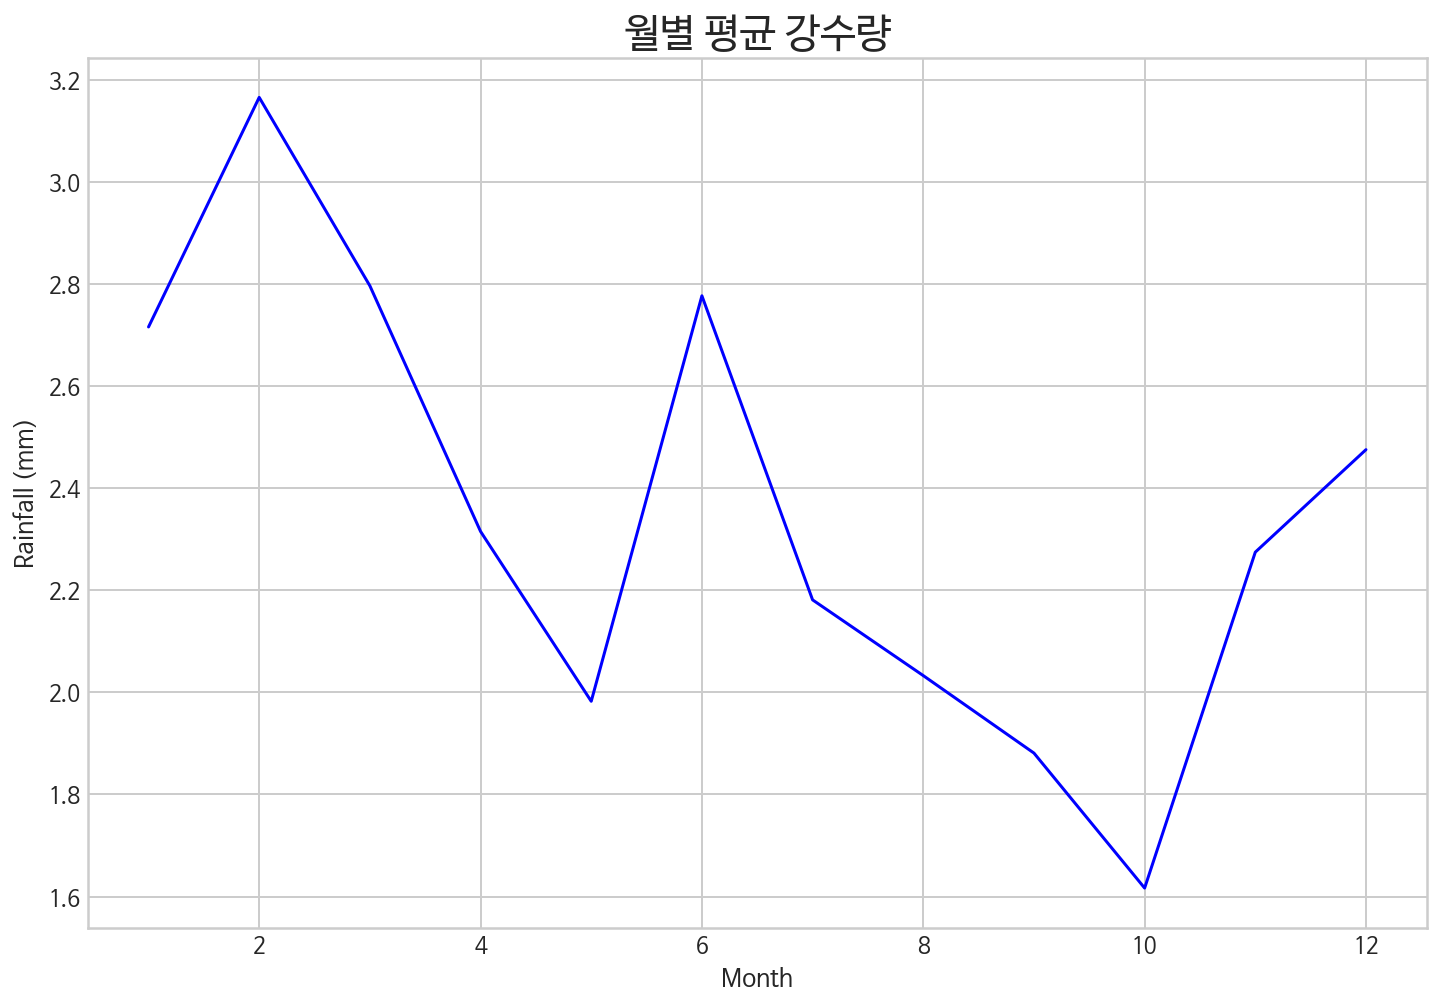

In [26]:
plt.rcParams['figure.figsize'] = (12, 8)
fig, ax1 = plt.subplots()

ax1.plot(df_month_rainfall['Month'], df_month_rainfall['Rainfall'], color='blue')
ax1.set_ylabel('Rainfall (mm)')
ax1.set_xlabel('Month')

ax1.tick_params(axis='both', direction='in')

plt.title('월별 평균 강수량', fontsize=20)
plt.show()

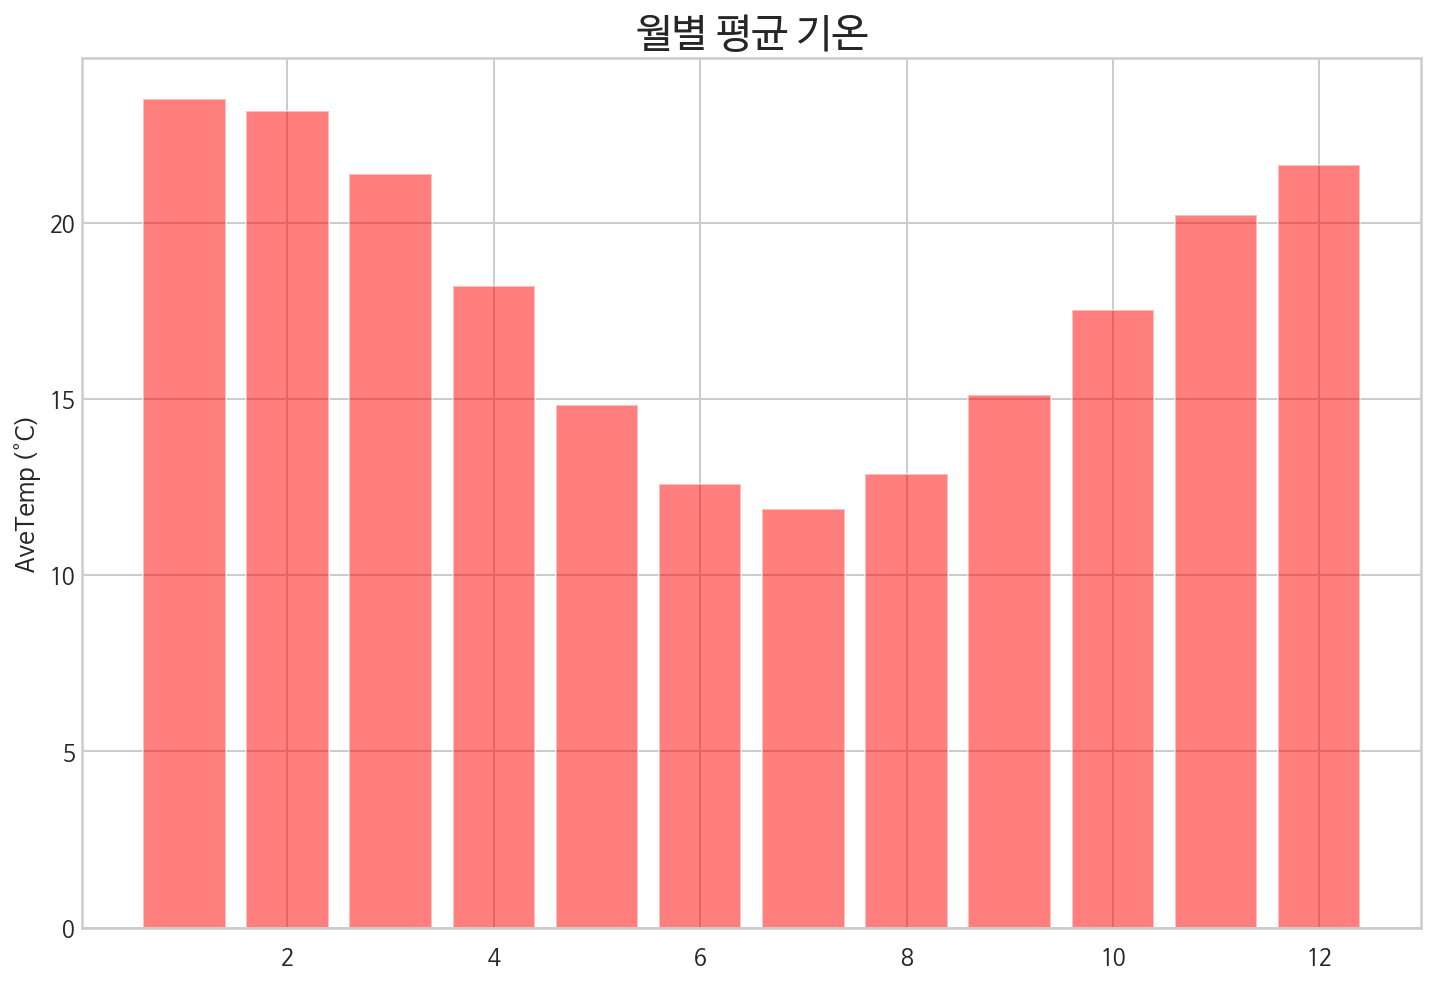

In [27]:
plt.rcParams['figure.figsize'] = (12, 8)
fig, ax2 = plt.subplots()
ax2.bar(df_month_rainfall['Month'], df_month_rainfall['AveTemp'], color='red', alpha=0.5)

ax2.set_ylabel('AveTemp (°C)')
ax2.tick_params(axis='y', direction='in')

plt.title('월별 평균 기온', fontsize=20)
plt.show()

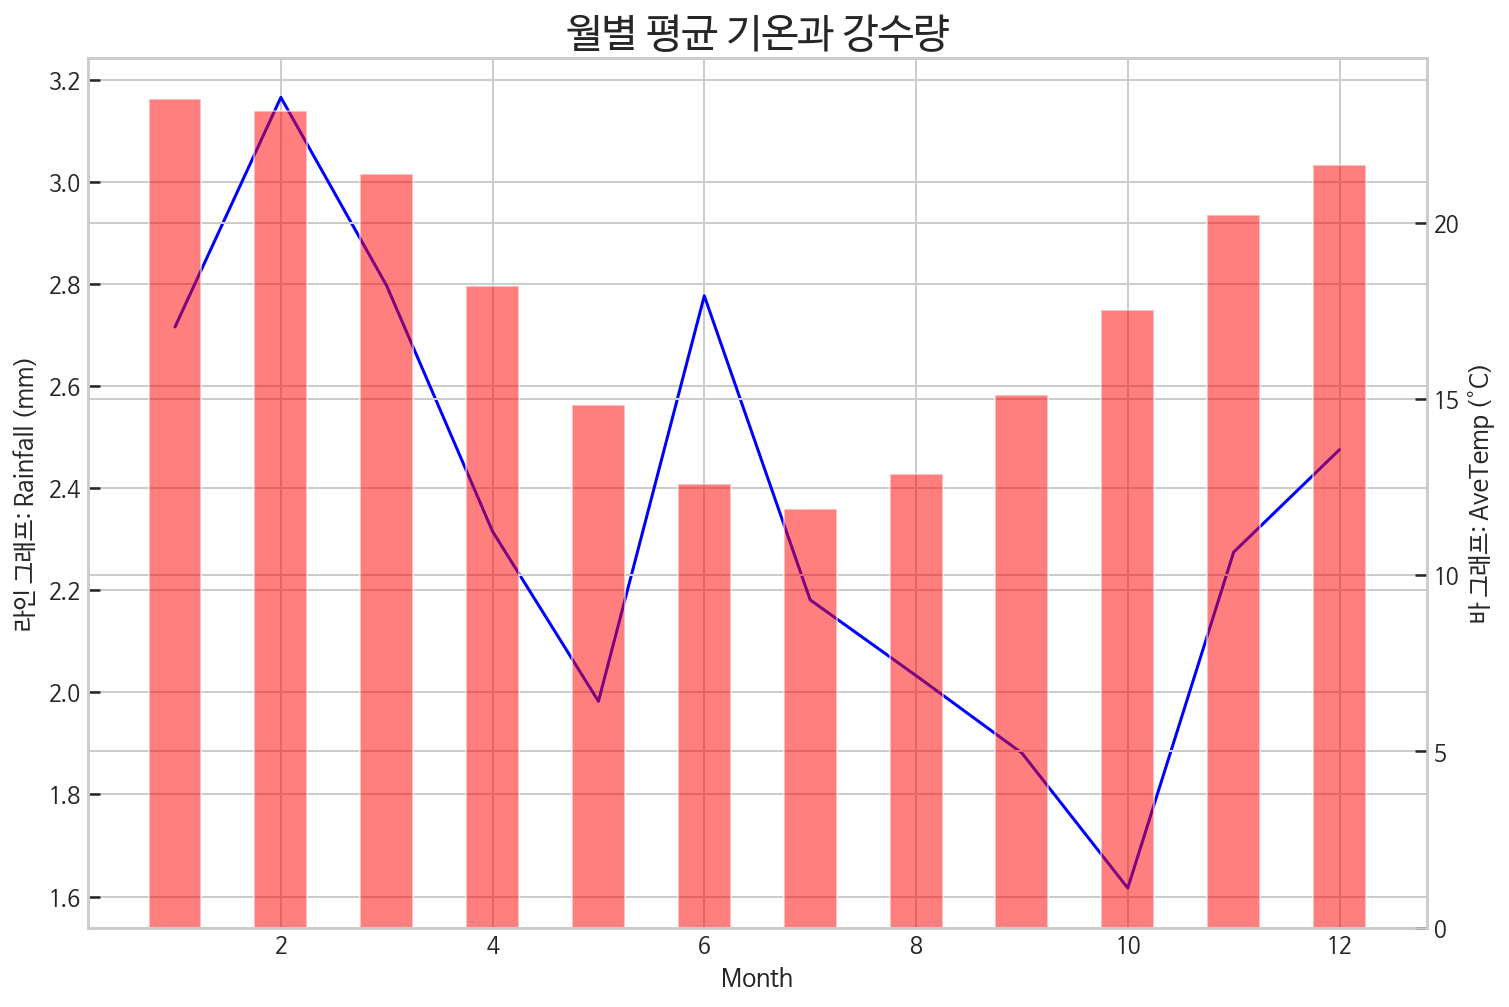

In [28]:
plt.rcParams['figure.figsize'] = (12, 8)
fig, ax1 = plt.subplots()

ax1.plot(df_month_rainfall['Month'], df_month_rainfall['Rainfall'], color='blue')
ax1.set_ylabel('라인 그래프: Rainfall (mm)')
ax1.set_xlabel('Month')

ax1.tick_params(axis='both', direction='in')

ax2 = ax1.twinx()
ax2.bar(df_month_rainfall['Month'], df_month_rainfall['AveTemp'], color='red', 
         alpha=0.5, width=0.5)

ax2.set_ylabel('바 그래프: AveTemp (°C)')
ax2.tick_params(axis='y', direction='in')

plt.title('월별 평균 기온과 강수량', fontsize=20)
plt.show()

In [62]:
df_summer_rain = df_preprocessed.groupby(['Summer']).agg({'RainToday': 'sum', 'Rainfall':'sum'})
df_summer_rain.columns = ['강우 횟수', '강수량 합계 (mm)']

df_summer_rain

,강우 횟수,강수량 합계 (mm)
Summer,,
0,24621,238992.522493
1,6834,95157.341056


In [55]:
df_summer = df_preprocessed['Summer'][df_preprocessed['Summer']==1]
len(df_summer)

34256

In [57]:
df_nonsummer = df_preprocessed['Summer'][df_preprocessed['Summer']==0]
len(df_nonsummer)

107937

In [56]:
a = 6834 / len(df_summer)
a

0.19949789817842128

In [58]:
b = 24621 / len(df_nonsummer)
b

0.22810528363767754

In [60]:
c = len(df_summer) + len(df_nonsummer)
c

142193

In [52]:
(df_preprocessed['RainToday']==0).sum()

110738

In [66]:
df_rain_ratio = df_summer_rain.copy()
df_rain_ratio['강우확률'] = [b, a]
df_rain_ratio

,강우 횟수,강수량 합계 (mm),강우확률
Summer,,,
0,24621,238992.522493,0.228105
1,6834,95157.341056,0.199498


In [68]:
rain_ratio = pd.DataFrame(df_rain_ratio['강우확률'])
rain_ratio

,강우확률
Summer,
0,0.228105
1,0.199498


In [47]:
ex = df_preprocessed[['Summer', 'RainToday', 'Rainfall']]
ex = ex.grouby('Summer')[].sum().sort_values(ascending=False) / df.shape[0]

,Summer,RainToday,Rainfall
0,1,0,0.6
1,1,0,0.0
2,1,0,0.0
3,1,0,0.0
4,1,0,1.0
...,...,...,...
145454,0,0,0.0
145455,0,0,0.0
145456,0,0,0.0
145457,0,0,0.0


(array([0, 1]), <a list of 2 Text xticklabel objects>)

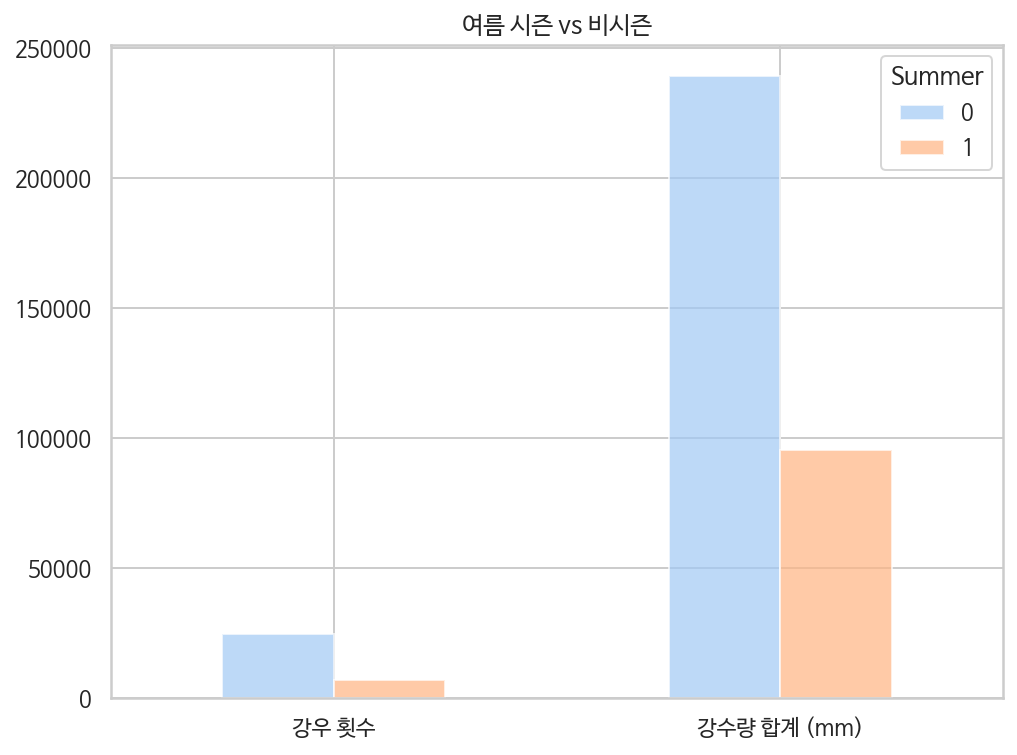

In [63]:
sns.set_palette('pastel')
summer_rain = df_summer_rain.T.plot.bar(figsize=(8, 6), alpha=0.7)
summer_rain.set_title('여름 시즌 vs 비시즌')
plt.xticks(rotation=0)

In [64]:
df_avg_rain = pd.DataFrame(df_summer_rain['강수량 합계 (mm)'] / df_summer_rain['강우 횟수'])
df_avg_rain.columns = ['강수량 평균']
df_avg_rain

,강수량 평균
Summer,
0,9.706857
1,13.924106


(array([0]), <a list of 1 Text xticklabel objects>)

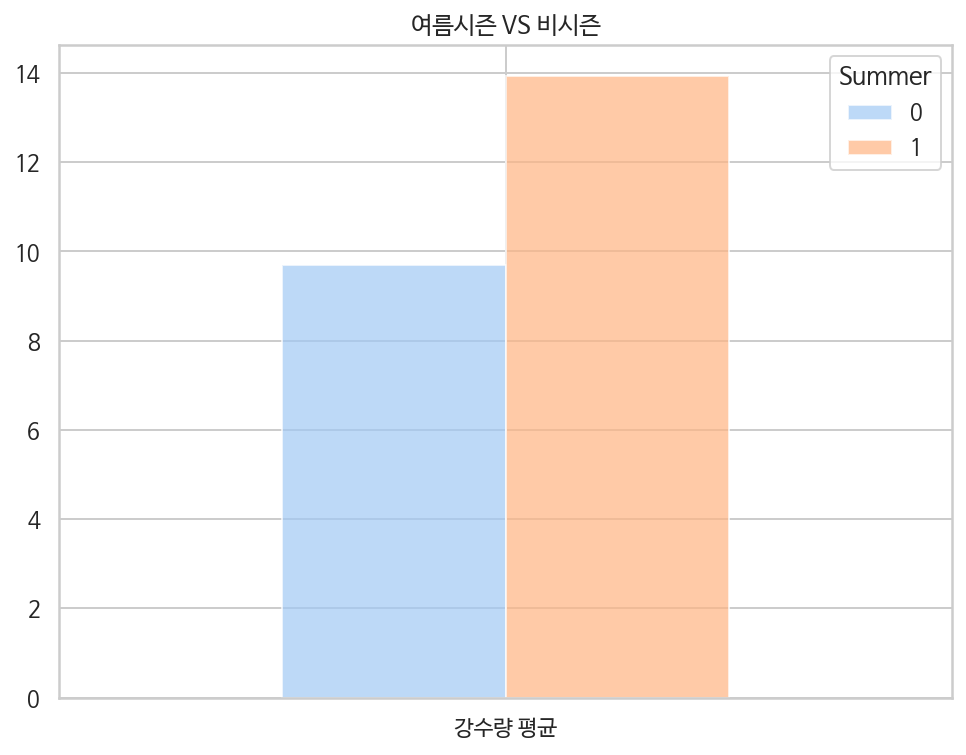

In [32]:
sns.set_palette('pastel')
avg_rain = df_avg_rain.T.plot.bar(figsize=(8, 6), alpha=0.7)
avg_rain.set_title('여름시즌 VS 비시즌')
plt.xticks(rotation=0)

(array([0]), <a list of 1 Text xticklabel objects>)

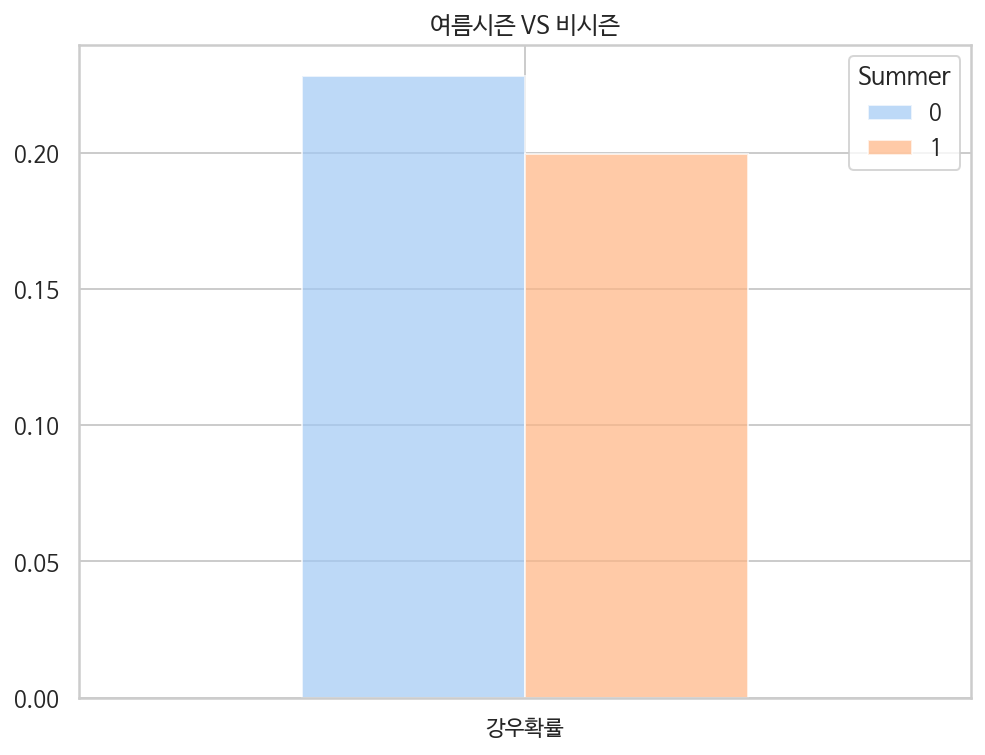

In [69]:
sns.set_palette('pastel')
avg_rain = rain_ratio.T.plot.bar(figsize=(8, 6), alpha=0.7)
avg_rain.set_title('여름시즌 VS 비시즌')
plt.xticks(rotation=0)

In [33]:
df_humidity = df_preprocessed[['RainTomorrow', 'AveHumidity']]
df_humidity.head(2)

,RainTomorrow,AveHumidity
0,0,46.5
1,0,34.5


Text(0.5, 1.0, '강우 여부에 따른 평균 습도 (%)')

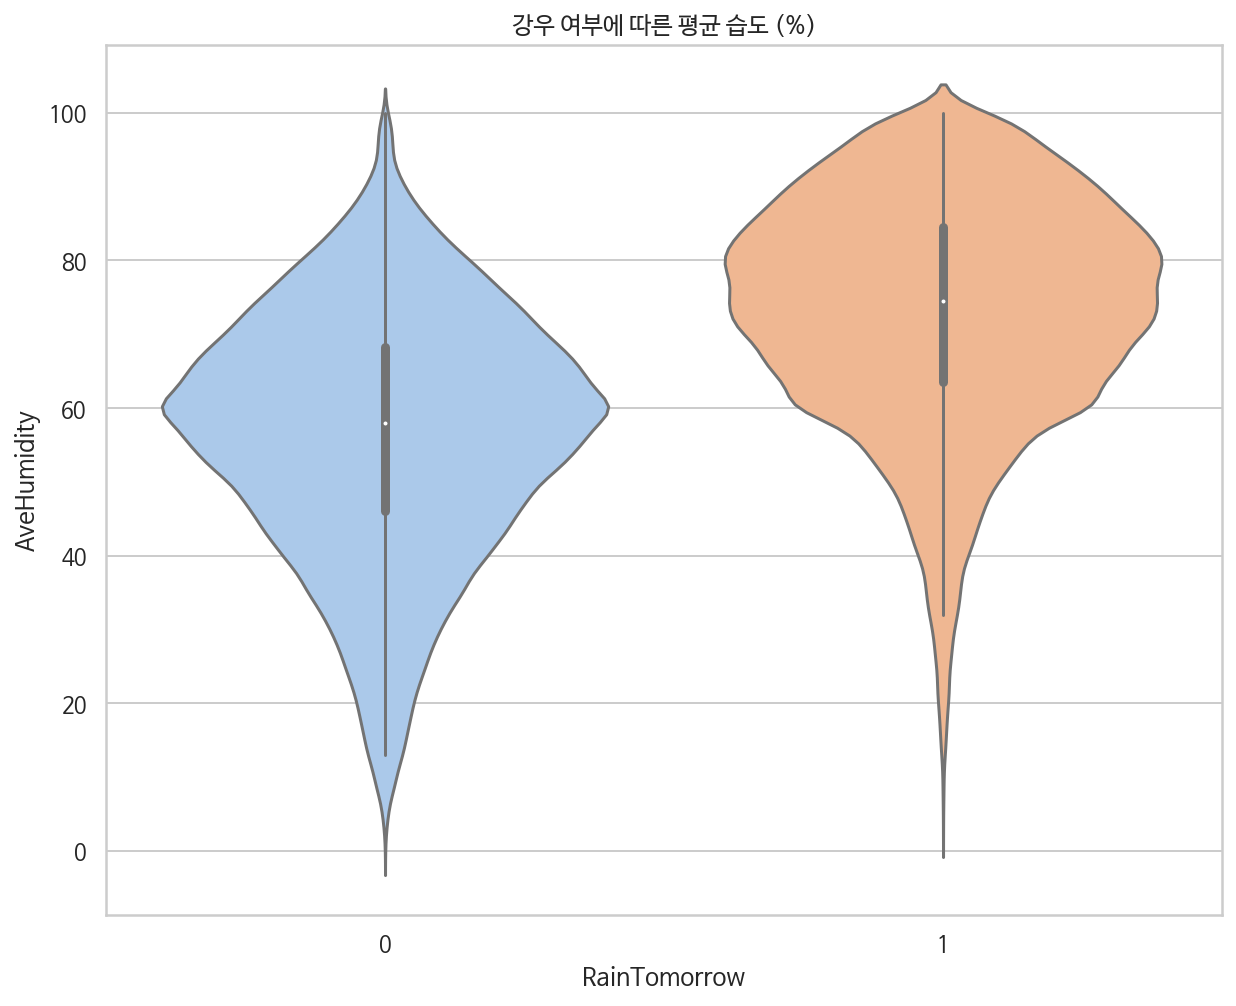

In [34]:
plt.figure(figsize = (10,8))
sns.set_palette('pastel')

a = sns.violinplot(x=df_humidity['RainTomorrow'], y=df_humidity['AveHumidity'])
a.set_title('강우 여부에 따른 평균 습도 (%)')

# 모델링

In [35]:
def split_data(df):

  features = df.drop(columns=[target]).columns

  train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])
  train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train[target])

  X_train = train[features]
  y_train = train[target]
  X_val = val[features]
  y_val = val[target]
  X_test = test[features]
  y_test = test[target] 

  return X_train, X_test, X_val, y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = split_data(df_preprocessed)  

In [36]:
# 골고루 잘 분배되었는가 확인
print("Train target distribution:\n", y_train.value_counts(normalize=True), "\n")
print("test target distribution:\n", y_test.value_counts(normalize=True), "\n")
print("val target distribution:\n", y_val.value_counts(normalize=True),"\n")

print('train: ', X_train.shape)
print('test: ', X_test.shape)
print('val: ', X_val.shape)

Train target distribution:
 0    0.77581
1    0.22419
Name: RainTomorrow, dtype: float64 

test target distribution:
 0    0.775836
1    0.224164
Name: RainTomorrow, dtype: float64 

val target distribution:
 0    0.775834
1    0.224166
Name: RainTomorrow, dtype: float64 

train:  (91003, 14)
test:  (28439, 14)
val:  (22751, 14)


In [37]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [38]:
# randomforest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight="balanced")

model_rf.fit(X_train_encoded, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [39]:
# AUC score & score report 구하는 함수 생성
def score_auc(model, X, y):
  y_pred = model.predict_proba(X)[:,1]
  print('AUC score : ', roc_auc_score(y, y_pred))
  print(classification_report
        (y, 
         model.predict(X)))

In [40]:
score_auc(model_rf, X_val_encoded, y_val)

AUC score :  0.8603117914776812
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     17651
           1       0.74      0.43      0.54      5100

    accuracy                           0.84     22751
   macro avg       0.80      0.69      0.72     22751
weighted avg       0.83      0.84      0.82     22751



In [41]:
#XGBoost model
model_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=2000,
    random_state=42,
)

watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model_xgb.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  
)

[0]	validation_0-auc:0.790743	validation_1-auc:0.786414
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.797225	validation_1-auc:0.793105
[2]	validation_0-auc:0.812817	validation_1-auc:0.808016
[3]	validation_0-auc:0.813749	validation_1-auc:0.808268
[4]	validation_0-auc:0.819576	validation_1-auc:0.813828
[5]	validation_0-auc:0.819813	validation_1-auc:0.814755
[6]	validation_0-auc:0.820794	validation_1-auc:0.815177
[7]	validation_0-auc:0.821144	validation_1-auc:0.815571
[8]	validation_0-auc:0.823431	validation_1-auc:0.818092
[9]	validation_0-auc:0.826876	validation_1-auc:0.821434
[10]	validation_0-auc:0.827168	validation_1-auc:0.821766
[11]	validation_0-auc:0.828163	validation_1-auc:0.822891
[12]	validation_0-auc:0.829917	validation_1-auc:0.824576
[13]	validation_0-auc:0.830907	validation_1-auc:0.826028
[14]	validation_0-auc:0.831472	validation_1-auc:0.82629

XGBClassifier(eval_metric='auc', n_estimators=2000, random_state=42)

In [42]:
score_auc(model_xgb, X_val_encoded, y_val)

AUC score :  0.8685311002764939
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     17651
           1       0.73      0.50      0.59      5100

    accuracy                           0.85     22751
   macro avg       0.80      0.72      0.75     22751
weighted avg       0.84      0.85      0.84     22751



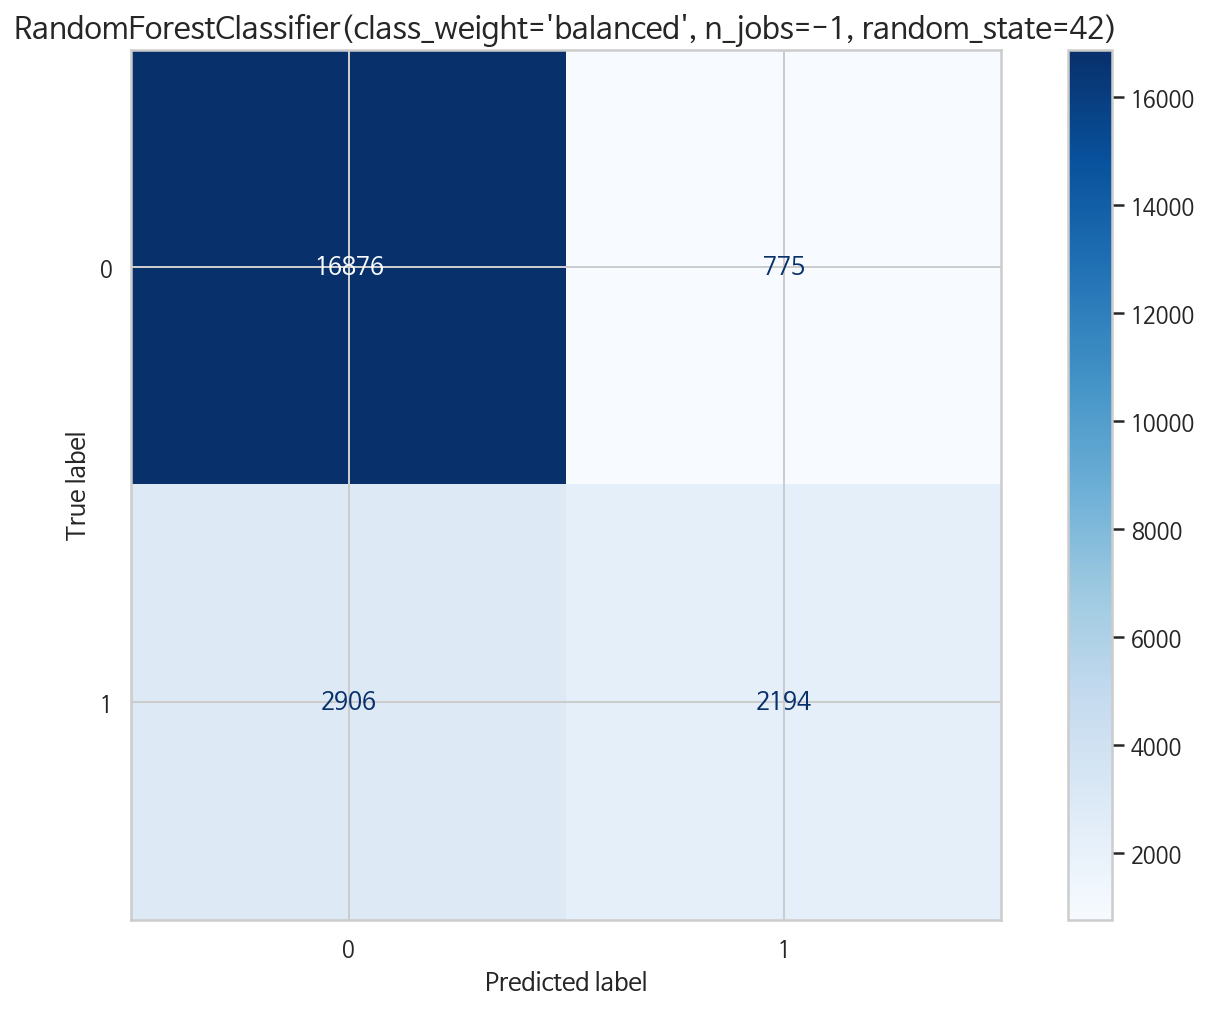

In [43]:
# confusion matrix 함수 생성
def plt_cm(model, X, y):
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X)
    else:
        y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.title(model, fontsize=15)
    plt.show()


plt_cm(model_rf, X_val_encoded, y_val)


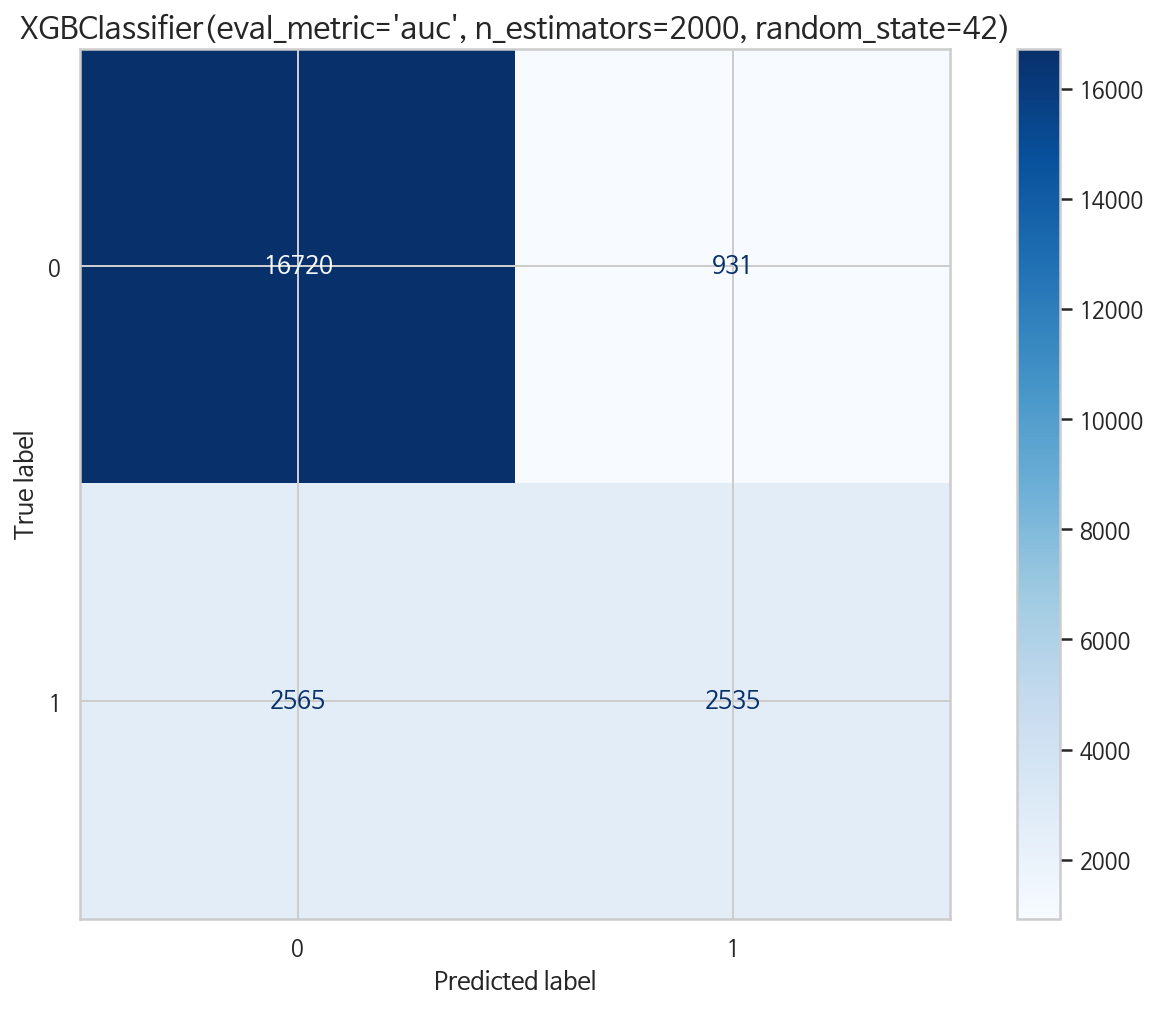

In [44]:
plt_cm(model_xgb, X_val_encoded, y_val)

Text(0.5, 1.0, 'feature Importance by RandomForest')

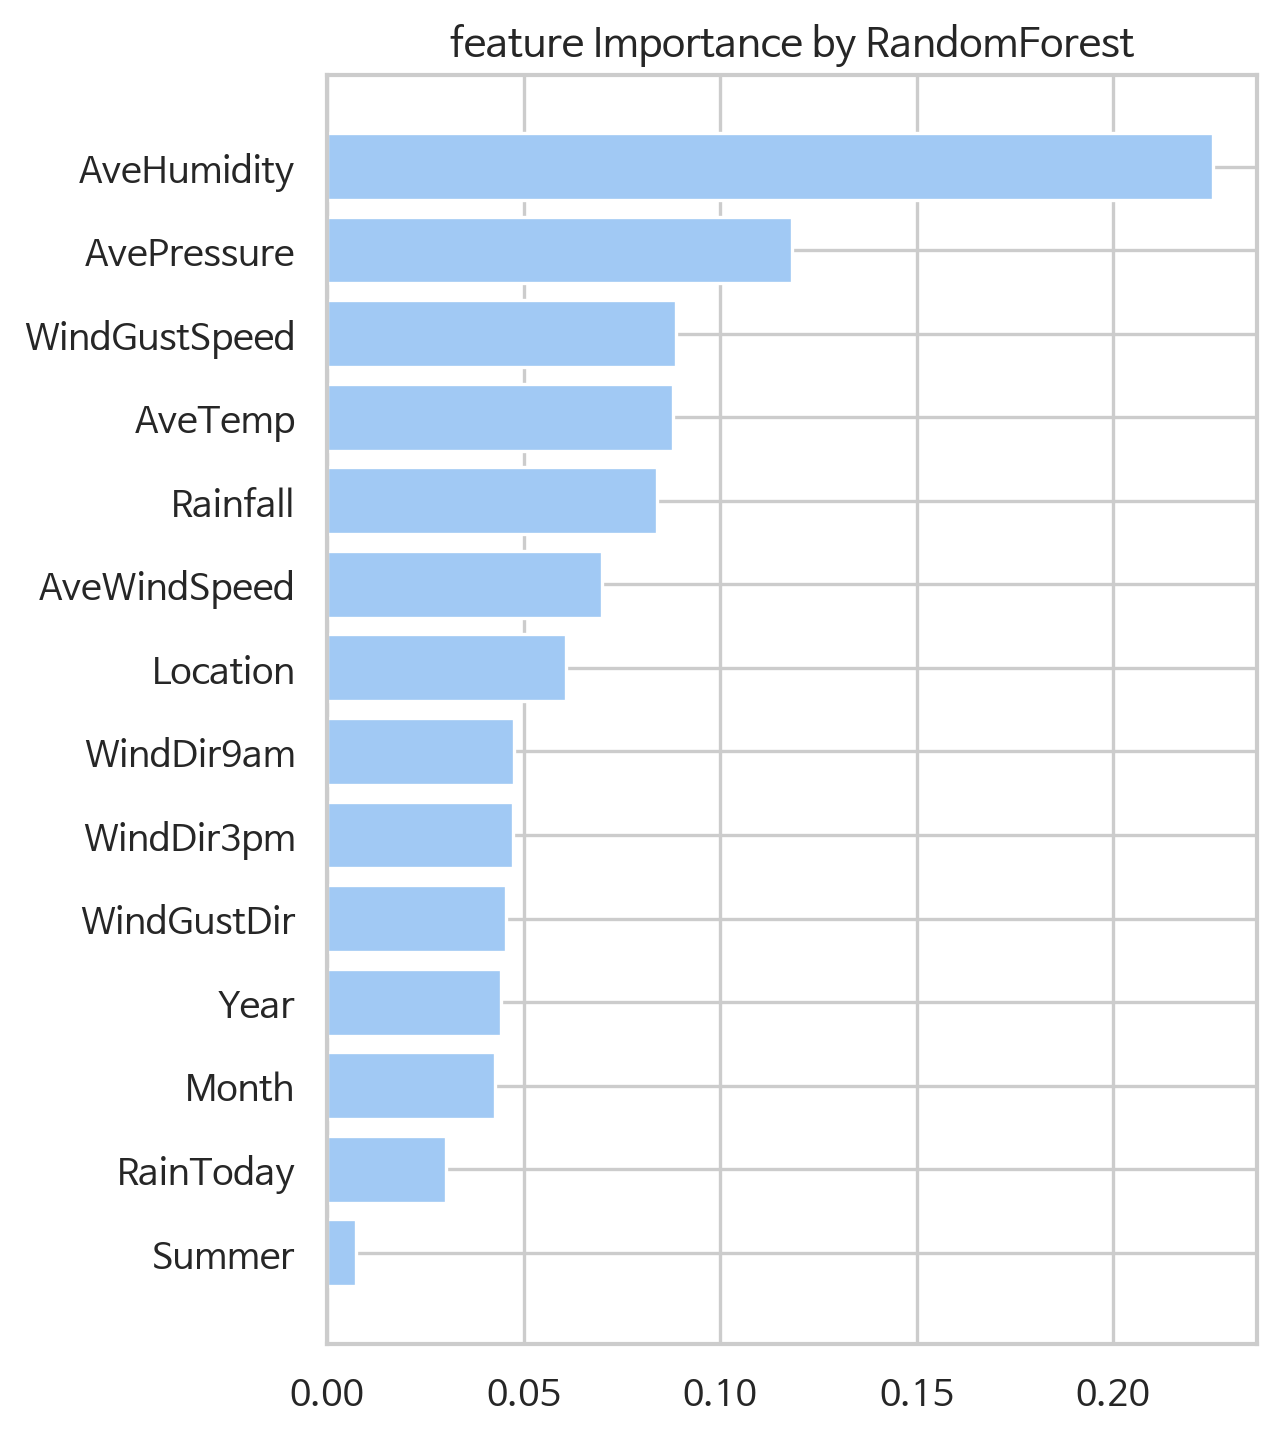

In [92]:
importance_rf = list(
    zip(X_train.columns, model_rf.feature_importances_))

feature_importances_rf = sorted(importance_rf, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(5, 7), dpi=120)
plt.barh(*list(zip(*feature_importances_rf[::-1])))
plt.title("feature Importance by RandomForest")

Text(0.5, 1.0, 'feature Importance by XGBoost')

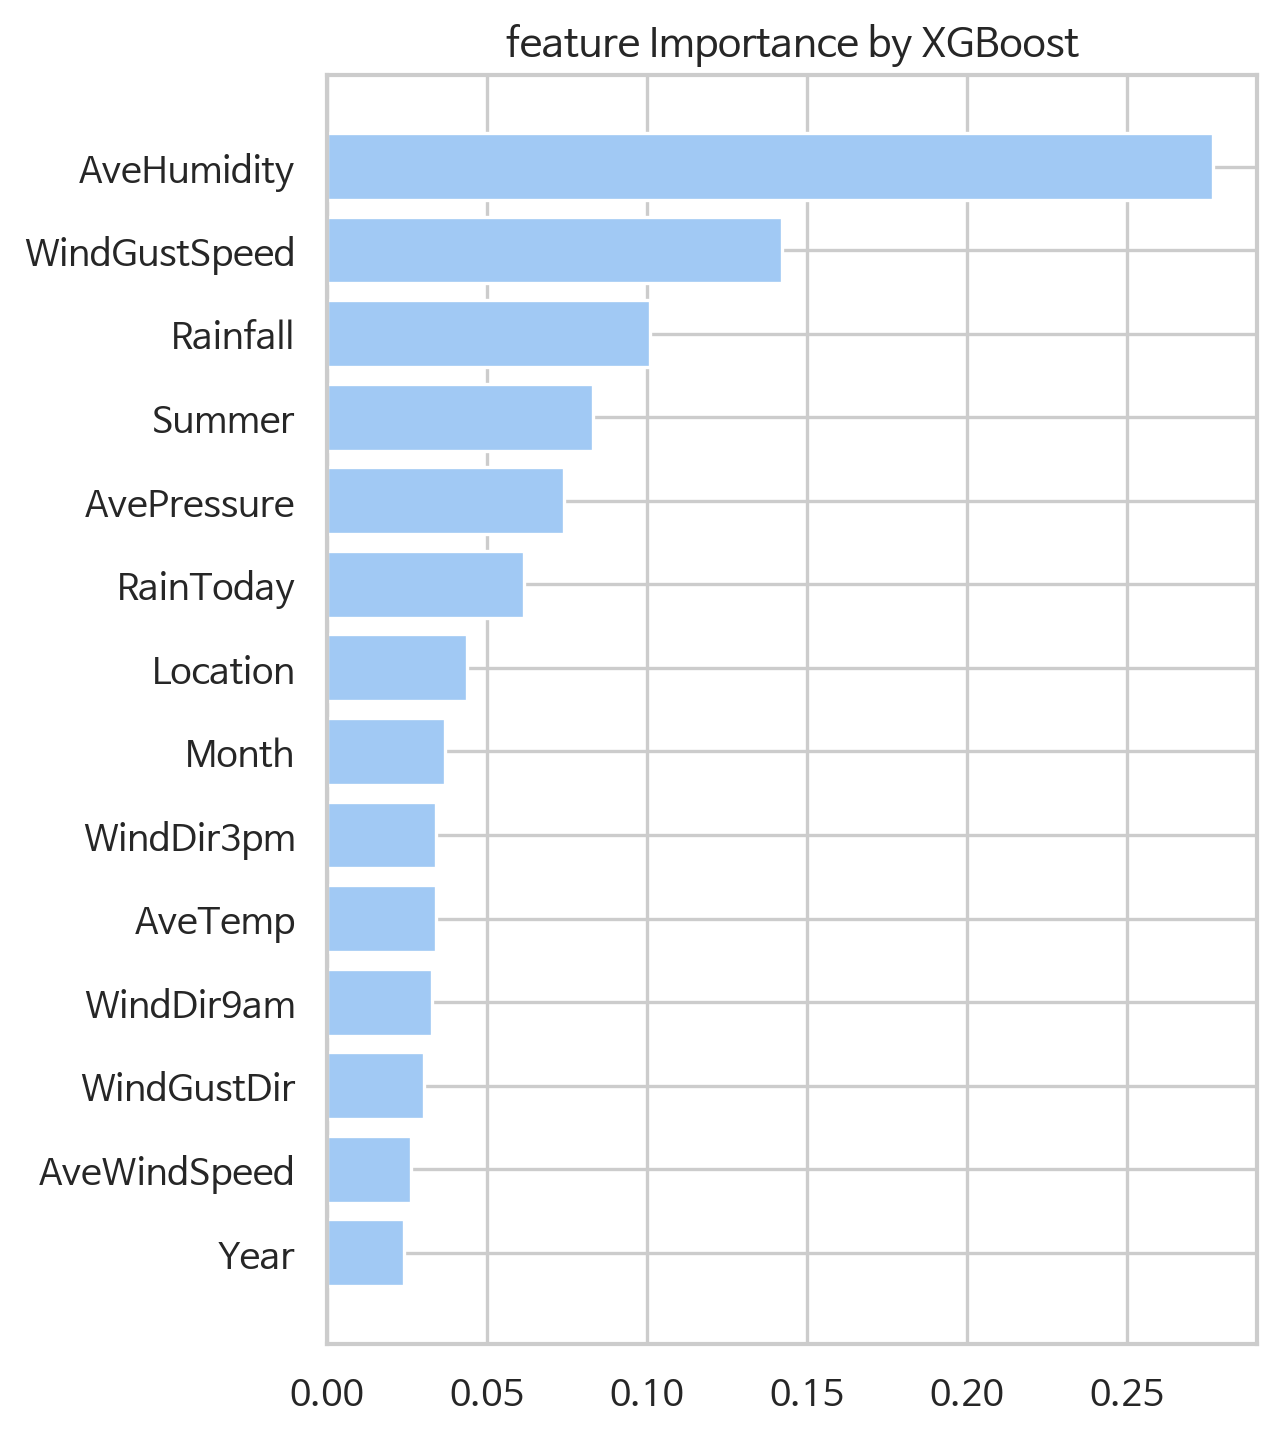

In [93]:
importance_xgb = list(
    zip(X_train.columns, model_xgb.feature_importances_))

feature_importances_xgb = sorted(importance_xgb, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(5, 7), dpi=120)
plt.barh(*list(zip(*feature_importances_xgb[::-1])))
plt.title("feature Importance by XGBoost")

In [77]:
permuter = PermutationImportance(
    model_xgb,
    scoring='roc_auc',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_encoded, y_val);

Text(0.5, 1.0, 'Permutation Importance')

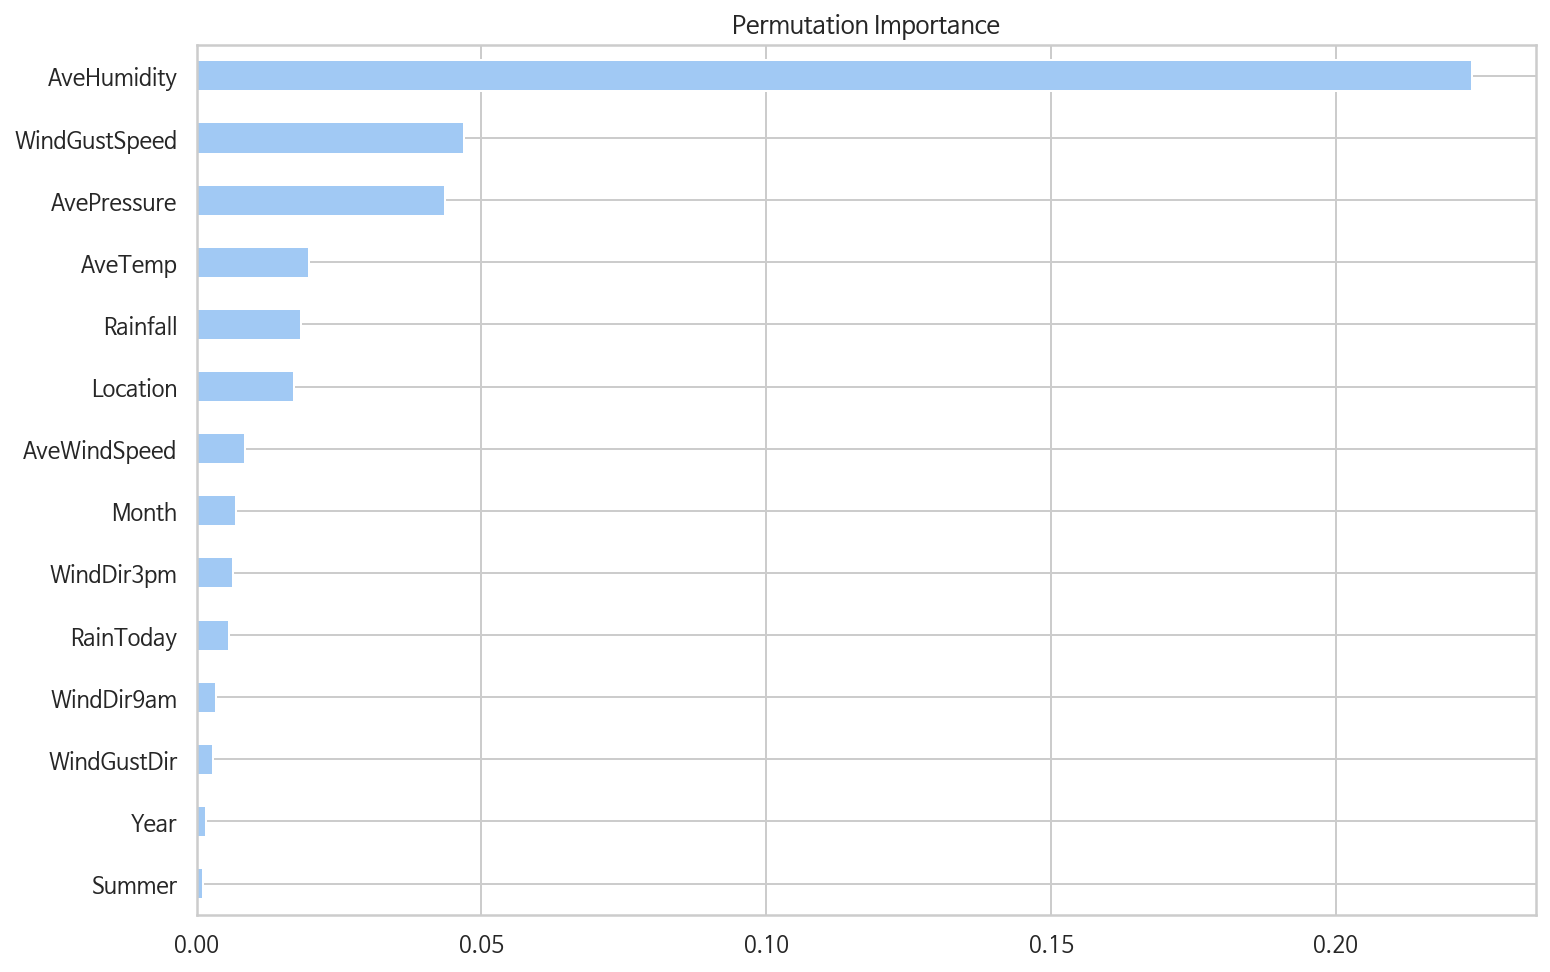

In [80]:
feature_names = X_val.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")

In [81]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names 
)

Weight,Feature
0.2239 ± 0.0042,AveHumidity
0.0470 ± 0.0032,WindGustSpeed
0.0437 ± 0.0013,AvePressure
0.0197 ± 0.0015,AveTemp
0.0183 ± 0.0017,Rainfall
0.0172 ± 0.0011,Location
0.0086 ± 0.0010,AveWindSpeed
0.0070 ± 0.0019,Month
0.0064 ± 0.0011,WindDir3pm
0.0057 ± 0.0009,RainToday


In [83]:
params = {
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__n_estimators": [10, 100, 200, 500, 1000, 2000],
    "xgbclassifier__learning_rate": [0.01, 0.2]
}

randomized_search = RandomizedSearchCV(
    model_xgb,
    param_distributions=params,
    scoring="roc_auc",
    n_iter=10,
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=2000;, score=0.866 total time= 1.4min
[CV 2/3] END xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=2000;, score=0.871 total time= 1.5min
[CV 3/3] END xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=2000;, score=0.871 total time= 1.4min
[CV 1/3] END xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=4, xgbclassifier__n_estimators=1000;, score=0.866 total time= 1.3min
[CV 2/3] END xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=4, xgbclassifier__n_estimators=1000;, score=0.871 total time= 1.3min
[CV 3/3] END xgbclassifier__learning_rate=0.01, xgbclassi

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(eval_metric='auc', n_estimators=2000,
                                           random_state=42),
                   param_distributions={'xgbclassifier__learning_rate': [0.01,
                                                                         0.2],
                                        'xgbclassifier__max_depth': [2, 4, 6],
                                        'xgbclassifier__min_child_weight': [2,
                                                                            4,
                                                                            8],
                                        'xgbclassifier__n_estimators': [10, 100,
                                                                        200,
                                                                        500,
                                                                        1000,
                                             

In [85]:
print('최적 하이퍼파라미터: ', randomized_search.best_params_)

최적 하이퍼파라미터:  {'xgbclassifier__n_estimators': 2000, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.2}


In [87]:
#XGBoost model (최적 하이퍼파라미터 튜닝)
model_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=2000,
    min_child_weight=2,
    max_depth=4,
    learning_rate=0.2,
    random_state=42)

watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model_xgb.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  
)

[0]	validation_0-auc:0.80911	validation_1-auc:0.802347
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.819638	validation_1-auc:0.812877
[2]	validation_0-auc:0.825013	validation_1-auc:0.818837
[3]	validation_0-auc:0.82844	validation_1-auc:0.82216
[4]	validation_0-auc:0.832087	validation_1-auc:0.825839
[5]	validation_0-auc:0.835012	validation_1-auc:0.828328
[6]	validation_0-auc:0.836727	validation_1-auc:0.830127
[7]	validation_0-auc:0.837895	validation_1-auc:0.831152
[8]	validation_0-auc:0.839287	validation_1-auc:0.832369
[9]	validation_0-auc:0.840079	validation_1-auc:0.83342
[10]	validation_0-auc:0.842034	validation_1-auc:0.835539
[11]	validation_0-auc:0.842954	validation_1-auc:0.836423
[12]	validation_0-auc:0.843642	validation_1-auc:0.836886
[13]	validation_0-auc:0.84486	validation_1-auc:0.837769
[14]	validation_0-auc:0.845937	validation_1-auc:0.838637
[15

XGBClassifier(eval_metric='auc', learning_rate=0.2, max_depth=4,
              min_child_weight=2, n_estimators=2000, random_state=42)

In [88]:
score_auc(model_xgb, X_val_encoded, y_val)

AUC score :  0.869698378473252
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     17651
           1       0.73      0.50      0.59      5100

    accuracy                           0.85     22751
   macro avg       0.80      0.72      0.75     22751
weighted avg       0.84      0.85      0.84     22751



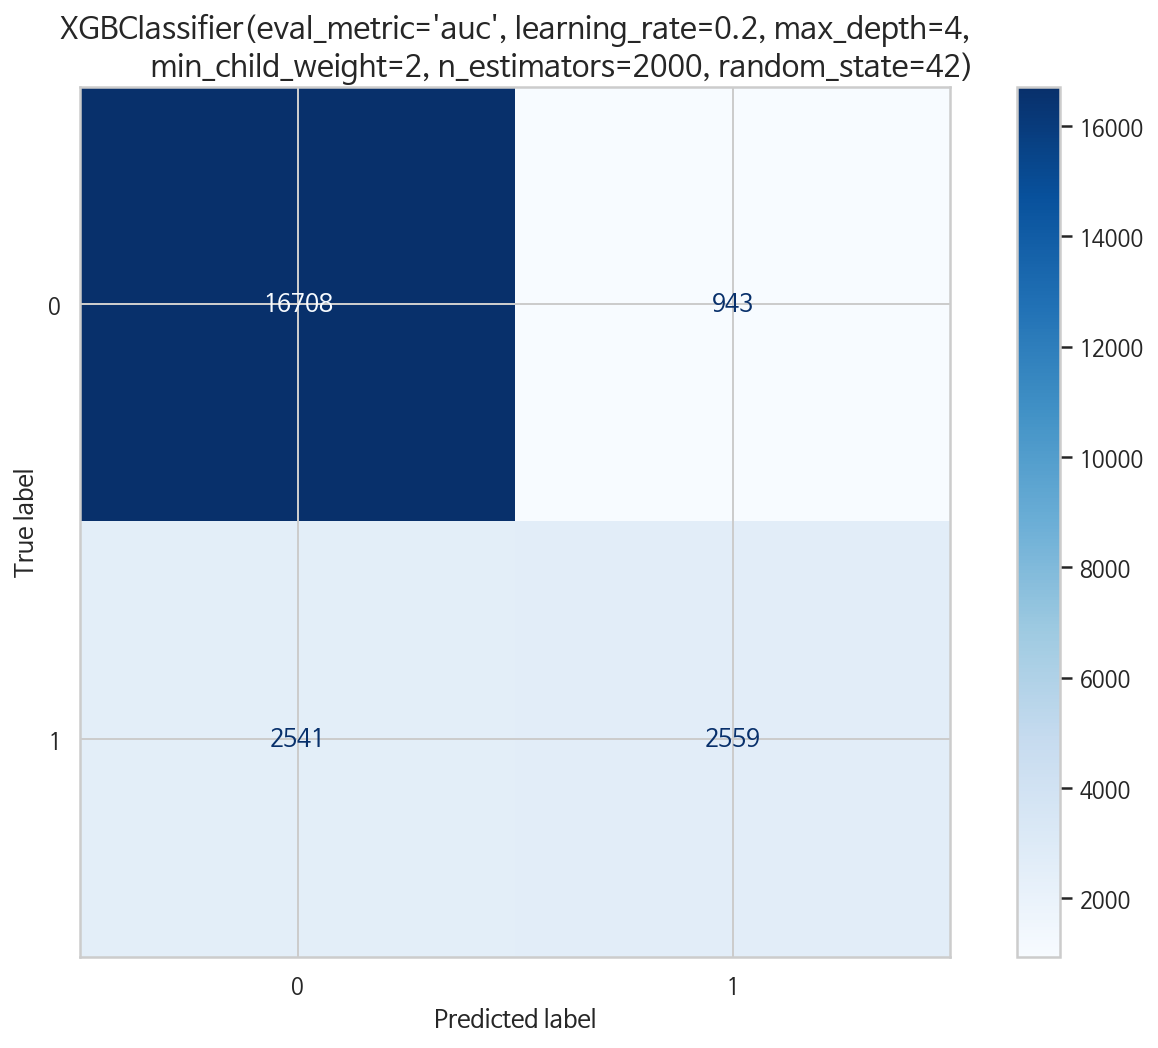

In [89]:
plt_cm(model_xgb, X_val_encoded, y_val)

Text(0.5, 1.0, 'Permutation Importance')

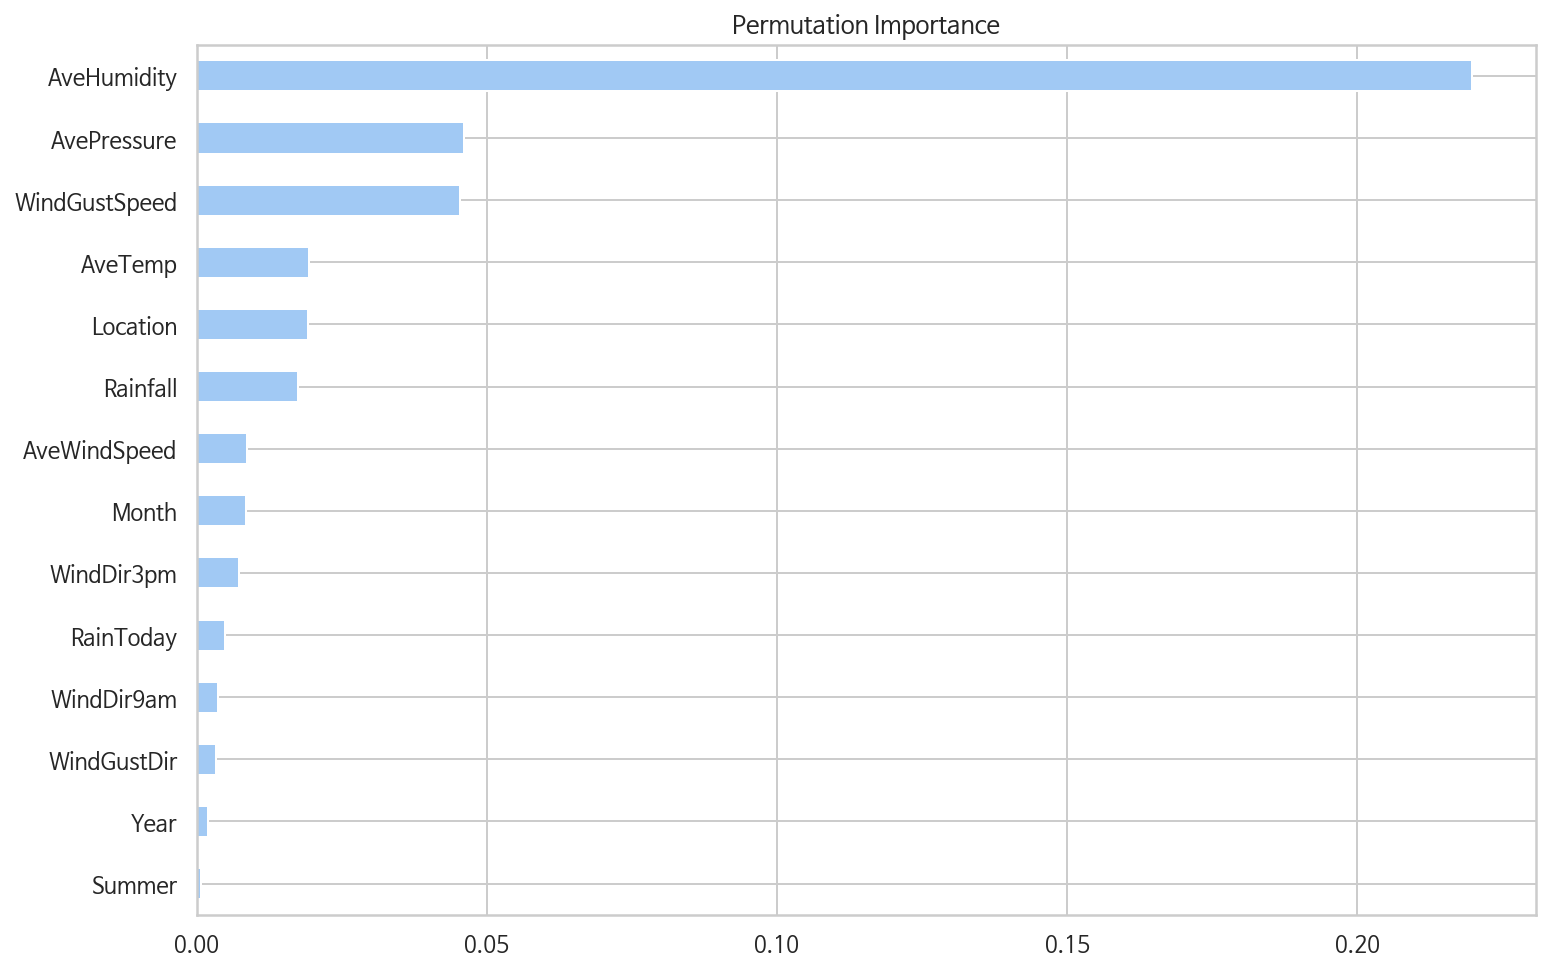

In [90]:
permuter = PermutationImportance(
    model_xgb,
    scoring='roc_auc',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_encoded, y_val);

feature_names = X_val.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")

In [91]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names 
)

Weight,Feature
0.2197 ± 0.0036,AveHumidity
0.0461 ± 0.0021,AvePressure
0.0454 ± 0.0031,WindGustSpeed
0.0193 ± 0.0010,AveTemp
0.0193 ± 0.0010,Location
0.0174 ± 0.0012,Rainfall
0.0086 ± 0.0014,AveWindSpeed
0.0086 ± 0.0017,Month
0.0073 ± 0.0012,WindDir3pm
0.0049 ± 0.0009,RainToday


In [94]:
score_auc(model_xgb, X_test_encoded, y_test)

AUC score :  0.8745186374042002
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     22064
           1       0.73      0.52      0.61      6375

    accuracy                           0.85     28439
   macro avg       0.80      0.73      0.76     28439
weighted avg       0.84      0.85      0.84     28439

